# Задача 1

Запустите у себя код из лекции в пункте "Реализация примера сети U-Net вручную"

In [1]:
import torch
import torch.nn as nn

In [2]:
def double_conv(in_c, out_c):
    conv = nn.Sequential(
        nn.Conv2d(in_c, out_c, kernel_size=3),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_c, out_c, kernel_size=3), # обратите внимание на неизменность каналов
        nn.ReLU(inplace=True)
    )
    return conv

In [3]:
def crop_img(tensor, target_tensor):
    target_size = target_tensor.size()[2] # Получает размер (высоту/ширину) целевого тензора (вектор предполагается квадратным [batch, channels, height, width])
    tensor_size = tensor.size()[2] # Получает размер входного тензора
    delta = tensor_size - target_size # Вычисляет разницу в размерах между входным и целевым тензором
    delta = delta // 2 # Делит разницу пополам (чтобы обрезать равномерно со всех сторон)
    return tensor[:, :, delta:tensor_size-delta, delta:tensor_size-delta]
    # Обрезает тензор по высоте и ширине, сохраняя batch и каналы
    # Напомним, что синтаксис срезов [start:end] означает взять элементы от start до end-1

In [4]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        self.max_pool_2x2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.down_conv_1 = double_conv(1, 64)
        self.down_conv_2 = double_conv(64, 128)
        self.down_conv_3 = double_conv(128, 256)
        self.down_conv_4 = double_conv(256, 512)
        self.down_conv_5 = double_conv(512, 1024)

        self.up_trans_1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.up_conv_1 = double_conv(1024, 512)
        self.up_trans_2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.up_conv_2 = double_conv(512, 256)
        self.up_trans_3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.up_conv_3 = double_conv(256, 128)
        self.up_trans_4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.up_conv_4 = double_conv(128, 64)
        self.out = nn.Conv2d(64, 2, kernel_size=1)

    def forward(self, image):
        # энкодер
        print('Энкодер')
        x1 = self.down_conv_1(image)
        print('После x1', x1.size())
        x2 = self.max_pool_2x2(x1)
        print('После x2', x2.size())
        x3 = self.down_conv_2(x2)
        print('После x3', x3.size())
        x4 = self.max_pool_2x2(x3)
        print('После x4', x4.size())
        x5 = self.down_conv_3(x4)
        print('После x5', x5.size())
        x6 = self.max_pool_2x2(x5)
        print('После x6', x6.size())
        x7 = self.down_conv_4(x6)
        print('После x7', x7.size())
        x8 = self.max_pool_2x2(x7)
        print('После x8', x8.size())
        x9 = self.down_conv_5(x8)
        print('После x9', x9.size())

        # декодер
        print('\nДекодер')
        x = self.up_trans_1(x9)
        print('После x', x.size())# 56x56
        print('После x7', x7.size()) # 64x64
        y = crop_img(x7, x)
        print('После y', y.size()) # 56x56
        x10 = self.up_conv_1(torch.cat([x, y], 1))
        print('После x10 (объединение и две свертки)', x10.size())# 52x52

        x = self.up_trans_2(x10)
        y = crop_img(x5, x)
        x11 = self.up_conv_2(torch.cat([x, y], 1))
        print('После x11', x11.size())

        x = self.up_trans_3(x11)
        y = crop_img(x3, x)
        x12 = self.up_conv_3(torch.cat([x, y], 1))
        print('После x12', x12.size())

        x = self.up_trans_4(x12)
        y = crop_img(x1, x)
        x13 = self.up_conv_4(torch.cat([x, y], 1))
        print('После x13', x13.size())

        x14 = self.out(x13)
        print('После x14', x14.size())
        return x14

In [5]:
image = torch.rand((1, 1, 572, 572))
model = UNet()
model(image)

Энкодер
После x1 torch.Size([1, 64, 568, 568])
После x2 torch.Size([1, 64, 284, 284])
После x3 torch.Size([1, 128, 280, 280])
После x4 torch.Size([1, 128, 140, 140])
После x5 torch.Size([1, 256, 136, 136])
После x6 torch.Size([1, 256, 68, 68])
После x7 torch.Size([1, 512, 64, 64])
После x8 torch.Size([1, 512, 32, 32])
После x9 torch.Size([1, 1024, 28, 28])

Декодер
После x torch.Size([1, 512, 56, 56])
После x7 torch.Size([1, 512, 64, 64])
После y torch.Size([1, 512, 56, 56])
После x10 (объединение и две свертки) torch.Size([1, 512, 52, 52])
После x11 torch.Size([1, 256, 100, 100])
После x12 torch.Size([1, 128, 196, 196])
После x13 torch.Size([1, 64, 388, 388])
После x14 torch.Size([1, 2, 388, 388])


tensor([[[[ 0.0809,  0.0806,  0.0832,  ...,  0.0796,  0.0867,  0.0830],
          [ 0.0775,  0.0795,  0.0822,  ...,  0.0831,  0.0818,  0.0810],
          [ 0.0749,  0.0810,  0.0746,  ...,  0.0849,  0.0809,  0.0776],
          ...,
          [ 0.0793,  0.0795,  0.0803,  ...,  0.0792,  0.0832,  0.0827],
          [ 0.0761,  0.0831,  0.0817,  ...,  0.0839,  0.0818,  0.0778],
          [ 0.0792,  0.0829,  0.0822,  ...,  0.0820,  0.0826,  0.0803]],

         [[-0.1371, -0.1293, -0.1366,  ..., -0.1358, -0.1345, -0.1376],
          [-0.1334, -0.1319, -0.1351,  ..., -0.1321, -0.1353, -0.1357],
          [-0.1310, -0.1352, -0.1295,  ..., -0.1411, -0.1319, -0.1323],
          ...,
          [-0.1373, -0.1323, -0.1377,  ..., -0.1360, -0.1394, -0.1385],
          [-0.1364, -0.1380, -0.1324,  ..., -0.1400, -0.1383, -0.1359],
          [-0.1397, -0.1375, -0.1361,  ..., -0.1419, -0.1398, -0.1412]]]],
       grad_fn=<ConvolutionBackward0>)

Увеличьте глубину UNet с дополнительными слоями. Для этого:

1. Добавьте еще один down/up блок (вместо 5 уровней сделайте 6)

2. Убедитесь, что размеры тензоров правильно согласованы

Посмотрите как это отразиться на результате

In [6]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        self.max_pool_2x2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.down_conv_1 = double_conv(1, 64)
        self.down_conv_2 = double_conv(64, 128)
        self.down_conv_3 = double_conv(128, 256)
        self.down_conv_4 = double_conv(256, 512)
        self.down_conv_5 = double_conv(512, 1024)
        self.down_conv_6 = double_conv(1024, 2048)

        self.up_trans_1 = nn.ConvTranspose2d(2048, 1024, kernel_size=2, stride=2)
        self.up_conv_1 = double_conv(2048, 1024)
        self.up_trans_2 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.up_conv_2 = double_conv(1024, 512)
        self.up_trans_3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.up_conv_3 = double_conv(512, 256)
        self.up_trans_4 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.up_conv_4 = double_conv(256, 128)
        self.up_trans_5 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.up_conv_5 = double_conv(128, 64)

        self.out = nn.Conv2d(64, 2, kernel_size=1)

    def forward(self, image):
        print('Энкодер')
        x1 = self.down_conv_1(image)
        print('x1', x1.size())
        x2 = self.max_pool_2x2(x1)
        x2 = self.down_conv_2(x2)
        print('x2', x2.size())
        x3 = self.max_pool_2x2(x2)
        x3 = self.down_conv_3(x3)
        print('x3', x3.size())
        x4 = self.max_pool_2x2(x3)
        x4 = self.down_conv_4(x4)
        print('x4', x4.size())
        x5 = self.max_pool_2x2(x4)
        x5 = self.down_conv_5(x5)
        print('x5', x5.size())
        x6 = self.max_pool_2x2(x5)
        x6 = self.down_conv_6(x6)
        print('x6', x6.size())

        print('\nДекодер')
        x = self.up_trans_1(x6)
        y = crop_img(x5, x)
        x = self.up_conv_1(torch.cat([x, y], 1))
        print('up1', x.size())

        x = self.up_trans_2(x)
        y = crop_img(x4, x)
        x = self.up_conv_2(torch.cat([x, y], 1))
        print('up2', x.size())

        x = self.up_trans_3(x)
        y = crop_img(x3, x)
        x = self.up_conv_3(torch.cat([x, y], 1))
        print('up3', x.size())

        x = self.up_trans_4(x)
        y = crop_img(x2, x)
        x = self.up_conv_4(torch.cat([x, y], 1))
        print('up4', x.size())

        x = self.up_trans_5(x)
        y = crop_img(x1, x)
        x = self.up_conv_5(torch.cat([x, y], 1))
        print('up5', x.size())

        out = self.out(x)
        print('Выходной размер', out.size())
        return out

In [7]:
image = torch.rand((1, 1, 572, 572))
model = UNet()
model(image)

Энкодер
x1 torch.Size([1, 64, 568, 568])
x2 torch.Size([1, 128, 280, 280])
x3 torch.Size([1, 256, 136, 136])
x4 torch.Size([1, 512, 64, 64])
x5 torch.Size([1, 1024, 28, 28])
x6 torch.Size([1, 2048, 10, 10])

Декодер
up1 torch.Size([1, 1024, 16, 16])
up2 torch.Size([1, 512, 28, 28])
up3 torch.Size([1, 256, 52, 52])
up4 torch.Size([1, 128, 100, 100])
up5 torch.Size([1, 64, 196, 196])
Выходной размер torch.Size([1, 2, 196, 196])


tensor([[[[0.0759, 0.0773, 0.0760,  ..., 0.0738, 0.0727, 0.0744],
          [0.0669, 0.0750, 0.0746,  ..., 0.0763, 0.0762, 0.0753],
          [0.0767, 0.0756, 0.0727,  ..., 0.0788, 0.0772, 0.0747],
          ...,
          [0.0776, 0.0756, 0.0723,  ..., 0.0800, 0.0773, 0.0680],
          [0.0736, 0.0745, 0.0770,  ..., 0.0766, 0.0696, 0.0740],
          [0.0749, 0.0768, 0.0754,  ..., 0.0746, 0.0725, 0.0798]],

         [[0.0154, 0.0182, 0.0136,  ..., 0.0210, 0.0144, 0.0147],
          [0.0162, 0.0170, 0.0150,  ..., 0.0162, 0.0130, 0.0170],
          [0.0118, 0.0153, 0.0171,  ..., 0.0174, 0.0157, 0.0151],
          ...,
          [0.0144, 0.0175, 0.0186,  ..., 0.0196, 0.0142, 0.0144],
          [0.0166, 0.0203, 0.0178,  ..., 0.0142, 0.0173, 0.0230],
          [0.0137, 0.0224, 0.0137,  ..., 0.0157, 0.0180, 0.0186]]]],
       grad_fn=<ConvolutionBackward0>)

# Задача 2

Пользуясь примером из лекции для сети U-Net на основе VGG16_bn, задайте архитектуру на основе ResNet, проведите обучение на том же датасете.

In [8]:
import os
if not os.path.exists('dataset1'):
    !wget https://github.com/alexgkendall/SegNet-Tutorial/archive/refs/heads/master.zip -O camvid.zip
    !unzip -q camvid.zip
    !rm camvid.zip

--2025-04-11 15:30:27--  https://github.com/alexgkendall/SegNet-Tutorial/archive/refs/heads/master.zip
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/alexgkendall/SegNet-Tutorial/zip/refs/heads/master [following]
--2025-04-11 15:30:27--  https://codeload.github.com/alexgkendall/SegNet-Tutorial/zip/refs/heads/master
Resolving codeload.github.com (codeload.github.com)... 20.205.243.165
Connecting to codeload.github.com (codeload.github.com)|20.205.243.165|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 187075221 (178M) [application/zip]
Saving to: ‘camvid.zip’

camvid.zip          100%[===================>] 178.41M  13.4MB/s    in 14s     

2025-04-11 15:30:42 (12.7 MB/s) - ‘camvid.zip’ saved [187075221/187075221]



In [9]:
%pip install -q torch_snippets==0.5

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 948.0/948.0 kB 53.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.7/220.7 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 99.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.7/161.7 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 69.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 100.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 kB 34.5 MB/s eta 0:00:00
   ━━━━

In [10]:
import torch
from torch_snippets import *
import torch.nn as nn
from torchvision import transforms
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import cv2
from torch import optim
from torch_snippets.torch_loader import Report

In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [12]:
tfms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [13]:
class SegData(Dataset):
    def __init__(self, split):
        self.items = stems(f'/content/SegNet-Tutorial-master/CamVid/{split}')
        self.split = split

    def __len__(self):
        return len(self.items)

    def __getitem__(self, ix):
        image = read(f'/content/SegNet-Tutorial-master/CamVid/{self.split}/{self.items[ix]}.png', 1)
        image = cv2.resize(image, (224,224))
        mask = read(f'/content/SegNet-Tutorial-master/CamVid/{self.split}annot/{self.items[ix]}.png', 0)
        mask = cv2.resize(mask, (224,224), interpolation=cv2.INTER_NEAREST)
        return image, mask

    def choose(self):
        return self[randint(len(self))]

    def collate_fn(self, batch):
        ims, masks = list(zip(*batch))
        ims = torch.cat([tfms(im.copy()/255.)[None] for im in ims]).float().to(device)
        ce_masks = torch.cat([torch.Tensor(mask[None]) for mask in masks]).long().to(device)
        return ims, ce_masks

In [14]:
items = stems(f'/content/SegNet-Tutorial-master/CamVid/test')
items[:3]

['Seq05VD_f02400', '0001TP_009720', 'Seq05VD_f00510']

In [15]:
trn_ds = SegData('train')
val_ds = SegData('test')
trn_dl = DataLoader(trn_ds, batch_size=4, shuffle=True, collate_fn=trn_ds.collate_fn)
val_dl = DataLoader(val_ds, batch_size=1, shuffle=True, collate_fn=val_ds.collate_fn)

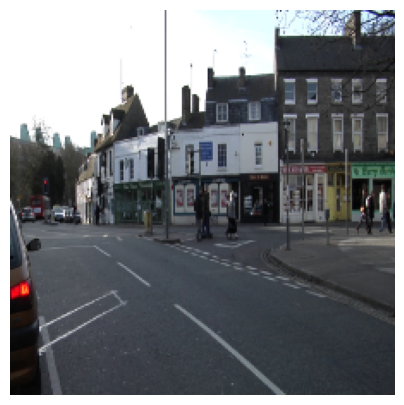

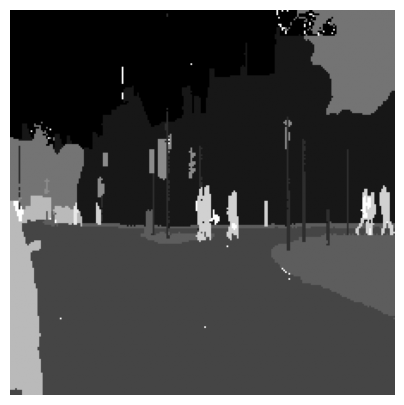

(None, None)

In [16]:
show(trn_ds[10][0]), show(trn_ds[10][1])

In [17]:
def conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )

def up_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
        nn.ReLU(inplace=True)
    )

In [18]:
from torchvision.models import resnet34

class ResNetUNet(nn.Module):
    def __init__(self, n_class=12, pretrained=True):
        super().__init__()
        self.base_model = resnet34(pretrained=pretrained)
        self.layer0 = nn.Sequential(
            self.base_model.conv1,
            self.base_model.bn1,
            self.base_model.relu,
        )
        self.maxpool = self.base_model.maxpool
        self.layer1 = self.base_model.layer1
        self.layer2 = self.base_model.layer2
        self.layer3 = self.base_model.layer3
        self.layer4 = self.base_model.layer4
        self.conv_bot = conv(512, 512)
        self.upconv4 = up_conv(512, 256)
        self.conv4 = conv(512, 256)
        self.upconv3 = up_conv(256, 128)
        self.conv3 = conv(256, 128)
        self.upconv2 = up_conv(128, 64)
        self.conv2 = conv(128, 64)
        self.upconv1 = up_conv(64, 64)
        self.conv1 = conv(128, 64)
        self.upconv0 = up_conv(64, 64)
        self.conv0 = conv(64, 64)
        self.out = nn.Conv2d(64, n_class, kernel_size=1)

    def forward(self, x):
        x0 = self.layer0(x)
        x1 = self.maxpool(x0)
        x1 = self.layer1(x1)
        x2 = self.layer2(x1)
        x3 = self.layer3(x2)
        x4 = self.layer4(x3)
        b = self.conv_bot(x4)
        d4 = self.upconv4(b)
        d4 = torch.cat([d4, x3], dim=1)
        d4 = self.conv4(d4)
        d3 = self.upconv3(d4)
        d3 = torch.cat([d3, x2], dim=1)
        d3 = self.conv3(d3)
        d2 = self.upconv2(d3)
        d2 = torch.cat([d2, x1], dim=1)
        d2 = self.conv2(d2)
        d1 = self.upconv1(d2)
        d1 = torch.cat([d1, x0], dim=1)
        d1 = self.conv1(d1)
        d0 = self.upconv0(d1)
        d0 = self.conv0(d0)
        out = self.out(d0)
        return out

In [19]:
ce = nn.CrossEntropyLoss()
def UnetLoss(preds, targets):
    ce_loss = ce(preds, targets)
    acc = (torch.max(preds, 1)[1] == targets).float().mean()
    return ce_loss, acc

def dice_score(preds, targets):
    preds = torch.softmax(preds, dim=1)
    intersect = (preds * targets).sum()
    union = preds.sum() + targets.sum()
    return 2 * intersect / union

In [20]:
def train_batch(model, data, optimizer, criterion):
    model.train()
    ims, ce_masks = data
    _masks = model(ims)
    optimizer.zero_grad()
    loss, acc = criterion(_masks, ce_masks)
    loss.backward()
    optimizer.step()
    return loss.item(), acc.item()

@torch.no_grad()
def validate_batch(model, data, criterion):
    model.eval()
    ims, masks = data
    _masks = model(ims)
    loss, acc = criterion(_masks, masks)
    return loss.item(), acc.item()

In [21]:
model = ResNetUNet(n_class=12).to(device)
criterion = UnetLoss
optimizer = optim.Adam(model.parameters(), lr=1e-3)
n_epochs = 10

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 176MB/s]


In [22]:
from tqdm import tqdm

log = Report(n_epochs)
for ex in range(n_epochs):
    train_loss_epoch = 0
    train_acc_epoch = 0
    for data in tqdm(trn_dl, desc=f'Epoch {ex+1}/{n_epochs} - Training'):
        loss, acc = train_batch(model, data, optimizer, criterion)
        train_loss_epoch += loss
        train_acc_epoch += acc
    train_loss_epoch /= len(trn_dl)
    train_acc_epoch /= len(trn_dl)

    val_loss_epoch = 0
    val_acc_epoch = 0
    for data in tqdm(val_dl, desc=f'Epoch {ex+1}/{n_epochs} - Validation'):
        loss, acc = validate_batch(model, data, criterion)
        val_loss_epoch += loss
        val_acc_epoch += acc
    val_loss_epoch /= len(val_dl)
    val_acc_epoch /= len(val_dl)

    log.record(ex+1, trn_loss=train_loss_epoch, trn_acc=train_acc_epoch,
               val_loss=val_loss_epoch, val_acc=val_acc_epoch)

Epoch 1/10 - Validation: 100%|██████████| 233/233 [00:04<00:00, 48.19it/s]


EPOCH: 1.000  trn_loss: 0.980  trn_acc: 0.737  val_loss: 0.842  val_acc: 0.728  (16.22s - 145.97s remaining)


Epoch 2/10 - Validation: 100%|██████████| 233/233 [00:07<00:00, 31.38it/s]


EPOCH: 2.000  trn_loss: 0.591  trn_acc: 0.833  val_loss: 0.724  val_acc: 0.786  (37.86s - 151.46s remaining)


Epoch 3/10 - Validation: 100%|██████████| 233/233 [00:04<00:00, 51.70it/s]


EPOCH: 3.000  trn_loss: 0.517  trn_acc: 0.849  val_loss: 0.751  val_acc: 0.788  (52.05s - 121.45s remaining)


Epoch 4/10 - Validation: 100%|██████████| 233/233 [00:10<00:00, 21.46it/s]


EPOCH: 4.000  trn_loss: 0.445  trn_acc: 0.867  val_loss: 0.575  val_acc: 0.836  (73.77s - 110.65s remaining)


Epoch 5/10 - Validation: 100%|██████████| 233/233 [00:04<00:00, 52.44it/s]


EPOCH: 5.000  trn_loss: 0.398  trn_acc: 0.879  val_loss: 0.761  val_acc: 0.757  (88.84s - 88.84s remaining)


Epoch 6/10 - Validation: 100%|██████████| 233/233 [00:04<00:00, 47.03it/s]


EPOCH: 6.000  trn_loss: 0.371  trn_acc: 0.884  val_loss: 0.654  val_acc: 0.806  (103.55s - 69.03s remaining)


Epoch 7/10 - Validation: 100%|██████████| 233/233 [00:04<00:00, 46.81it/s]


EPOCH: 7.000  trn_loss: 0.332  trn_acc: 0.896  val_loss: 0.629  val_acc: 0.799  (117.96s - 50.56s remaining)


Epoch 8/10 - Validation: 100%|██████████| 233/233 [00:04<00:00, 52.64it/s]


EPOCH: 8.000  trn_loss: 0.311  trn_acc: 0.902  val_loss: 0.683  val_acc: 0.821  (132.20s - 33.05s remaining)


Epoch 9/10 - Validation: 100%|██████████| 233/233 [00:04<00:00, 52.33it/s]


EPOCH: 9.000  trn_loss: 0.306  trn_acc: 0.903  val_loss: 0.714  val_acc: 0.790  (147.55s - 16.39s remaining)


Epoch 10/10 - Validation: 100%|██████████| 233/233 [00:04<00:00, 50.76it/s]

EPOCH: 10.000  trn_loss: 0.292  trn_acc: 0.907  val_loss: 0.603  val_acc: 0.814  (162.06s - 0.00s remaining)


100%|██████████| 111/111 [00:00<00:00, 73144.97it/s]


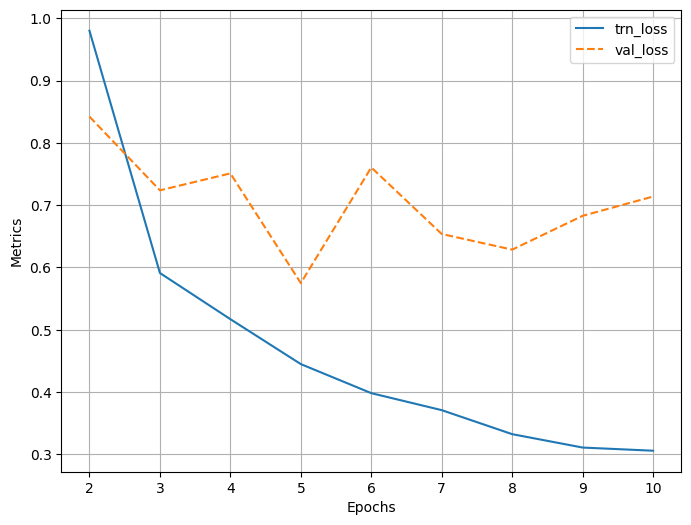

In [23]:
log.plot_epochs(['trn_loss','val_loss'])

In [24]:
im, mask = next(iter(val_dl))
_mask = model(im)
_, _mask = torch.max(_mask, dim=1)

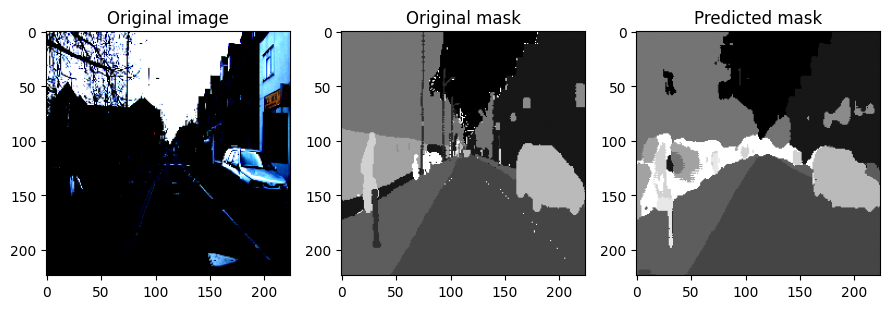

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(9, 3))

plt.subplot(1, 3, 1)
plt.imshow(im[0].permute(1,2,0).detach().cpu().numpy())
plt.title('Original image')

plt.subplot(1, 3, 2)
plt.imshow(mask.permute(1,2,0).detach().cpu().numpy(), cmap='gray')
plt.title('Original mask')

plt.subplot(1, 3, 3)
plt.imshow(_mask.permute(1,2,0).detach().cpu().numpy(), cmap='gray')
plt.title('Predicted mask')

plt.tight_layout()
plt.show()

100%|██████████| 111/111 [00:00<00:00, 146083.38it/s]


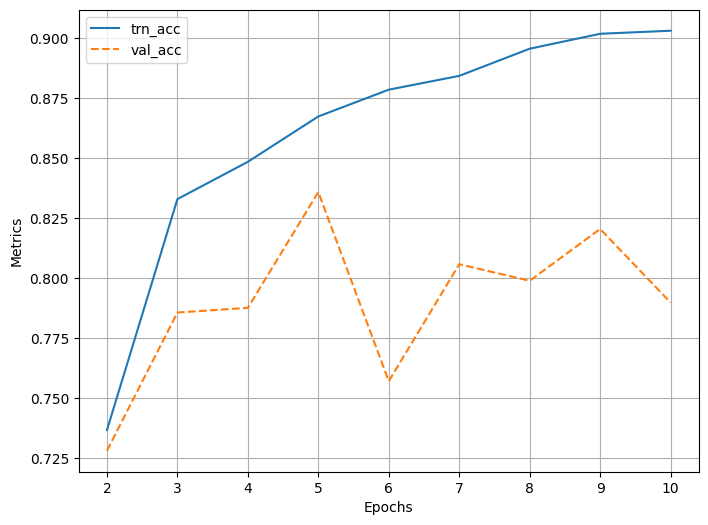

In [26]:
log.plot_epochs(['trn_acc','val_acc'])